## Table of contents:

1. [Importing libraries](#Libraries)
2. [Loading data](#Data)
3. [CNN Model](#CNN)
4. [RNN Model](#RNN)
5. [Autoencoder](#Autoencoder)
6. [Conclusion](#Conclusion)

<a name="Libraries"></a>
# 1. Importing libraries

In [1]:
import os
import cv2
import imghdr
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2832\2356175121.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [88]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

#### Avoiding errors

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

The above code was to enable memory growth, therefore enabling TensorFlow to dynamically allocate memory on the GPU, which helps prevent OOM errors that may occur when the default behavior allocates a large portion of GPU memory at the beginning, potentially exhausting the available memory.

<a name="Data"></a>
# 2. Load dataset

In [6]:
data_dir = r'C:\Users\ADMIN\Documents\funke\dataset'

#filename = 'vlcsnap-2023-06-08-15h39m23s529 (3).png'
#image_path = os.path.join(data_dir, 'dataset', filename)

#img = cv2.imread(image_path)

In [7]:
os.listdir(data_dir)

['authentic', 'fake']

## Data Augmentation

In [24]:
# Load the dataset using ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load the original dataset
data = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Calculate the number of additional images needed to reach 1200
total_images_needed = 1200 - data.samples

# Generate and save augmented images
augmented_count = 0
for i in range(total_images_needed // data.batch_size + 1):
    if augmented_count >= total_images_needed:
        break
    
    for images, labels in data:
        if augmented_count >= total_images_needed:
            break
        
        for j in range(len(images)):
            image = images[j]
            label = labels[j]

            augmented_image = datagen.random_transform(image)
            
            # Determine the class folder
            class_folder = data.class_indices
            class_name = list(class_folder.keys())[list(class_folder.values()).index(label.argmax())]
            
            # Get the path to the class subdirectory
            class_subdirectory = os.path.join(data_dir, class_name)
            
            # Create the augmented filename
            augmented_filename = f"augmented_{augmented_count}.png"
            
            # Create the augmented image path
            augmented_image_path = os.path.join(class_subdirectory, augmented_filename)
            
            # Save the augmented image
            tf.keras.preprocessing.image.save_img(augmented_image_path, augmented_image)
            
            augmented_count += 1


Found 197 images belonging to 2 classes.


### Feature Extraction

In [4]:
data_dir = r'C:\Users\ADMIN\Documents\funke\dataset'

In [5]:
#Building Data pipeline
data = tf.keras.utils.image_dataset_from_directory(data_dir,shuffle=True)

Found 1214 files belonging to 2 classes.


In [49]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, shuffle=True, image_size=(128, 128))

Found 1214 files belonging to 2 classes.


In [50]:
#Building Data pipeline
data_iterator = data.as_numpy_iterator()

In [51]:
# Acessing Datapipeline
batch = data_iterator.next()

In [52]:
batch[0].shape

(32, 128, 128, 3)

In [53]:
batch[1]

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1])

In [54]:
# Convert the features array into a DataFrame
df_features = pd.DataFrame(batch[1])
print(df_features)

    0
0   0
1   0
2   0
3   0
4   1
5   1
6   1
7   0
8   0
9   1
10  1
11  0
12  0
13  1
14  1
15  1
16  1
17  0
18  1
19  1
20  1
21  1
22  0
23  0
24  0
25  0
26  1
27  1
28  1
29  1
30  0
31  1


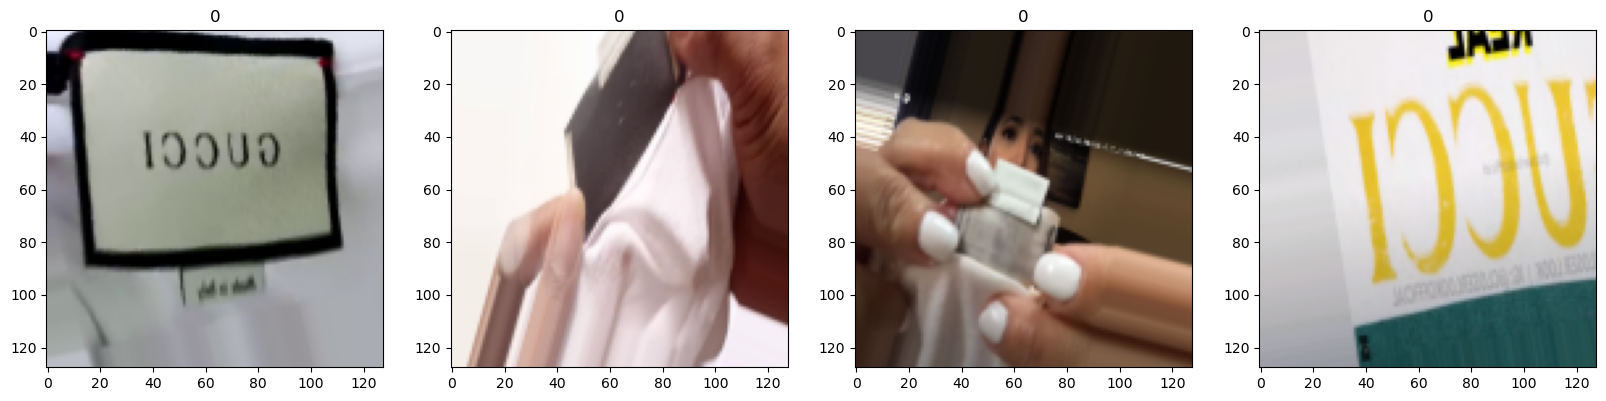

In [55]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])


0 = authentic
1 = fake

#### Scale data

In [56]:
data = data.map(lambda x, y: (x / 255.0, y))  # Scale images to [0, 1]

In [57]:
data.as_numpy_iterator().next()[0].min()

0.0

#### Split data

In [58]:
len(data)

38

In [59]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [60]:
train_size+val_size+test_size

36

In [61]:
train_size

26

In [62]:
val_size

7

In [63]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [64]:
len(test)

3

# Build Deep Learning Models

<a name="CNN"></a>
# 3. CNN Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import torch
import torchvision

In [109]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Instantiate the Sequential model
NN_model_1 = Sequential()

# Add the layers as you've defined
NN_model_1.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
NN_model_1.add(MaxPooling2D())
NN_model_1.add(Dropout(0.25))

NN_model_1.add(Conv2D(128, (3, 3), activation='relu'))
NN_model_1.add(MaxPooling2D())
NN_model_1.add(Dropout(0.25))

NN_model_1.add(Conv2D(256, (3, 3), activation='relu'))
NN_model_1.add(MaxPooling2D())
NN_model_1.add(Dropout(0.25))

NN_model_1.add(Flatten())
   
NN_model_1.add(Dense(512, activation='relu'))
NN_model_1.add(Dropout(0.5))
NN_model_1.add(Dense(1, activation='sigmoid'))



In [107]:
# Compile the model
NN_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
NN_model_1.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 63, 63, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_26 (Dropout)        (None, 63, 63, 64)        0         
                                                                 
 conv2d_54 (Conv2D)          (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 30, 30, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_27 (Dropout)        (None, 30, 30, 128)     

In [108]:
# Train the model with the profiler callback
history_2 = NN_model_1.fit(train, epochs=30, validation_data=val,
                         batch_size=64, verbose=1,
                         callbacks=[profiler_callback])

Epoch 1/30
26/26 [==============================] - 111s 4s/step - loss: 1.0361 - accuracy: 0.5252 - val_loss: 0.6932 - val_accuracy: 0.4955
Epoch 2/30
26/26 [==============================] - 110s 4s/step - loss: 0.6925 - accuracy: 0.5361 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/30
26/26 [==============================] - 116s 4s/step - loss: 0.6907 - accuracy: 0.5529 - val_loss: 0.6957 - val_accuracy: 0.4598
Epoch 4/30
26/26 [==============================] - 87s 3s/step - loss: 0.6932 - accuracy: 0.5649 - val_loss: 0.6914 - val_accuracy: 0.5134
Epoch 5/30
26/26 [==============================] - 93s 3s/step - loss: 0.6757 - accuracy: 0.6106 - val_loss: 0.6711 - val_accuracy: 0.5848
Epoch 6/30
26/26 [==============================] - 90s 3s/step - loss: 0.6653 - accuracy: 0.6154 - val_loss: 0.6663 - val_accuracy: 0.5982
Epoch 7/30
26/26 [==============================] - 99s 3s/step - loss: 0.6322 - accuracy: 0.6538 - val_loss: 0.6288 - val_accuracy: 0.5982
Epoch 8/30
26/26 

In [110]:
test_loss, test_accuracy = NN_model_1.evaluate(test)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

3/3 [==============================] - 16s 537ms/step - loss: 1.2088 - accuracy: 0.7188
Test loss: 1.2087947130203247, Test accuracy: 0.71875


### Plot Performance

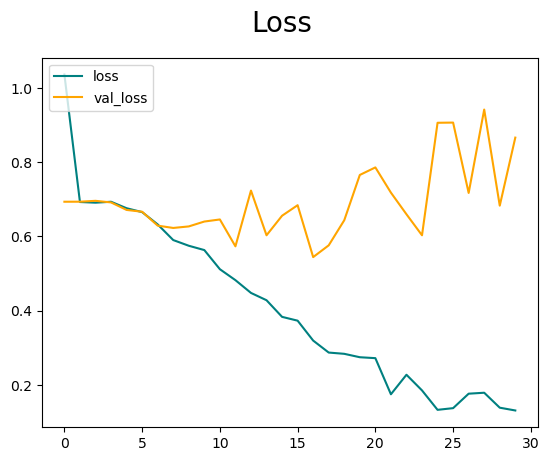

In [111]:
fig = plt.figure()
plt.plot(history_2.history['loss'], color='teal', label='loss')
plt.plot(history_2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

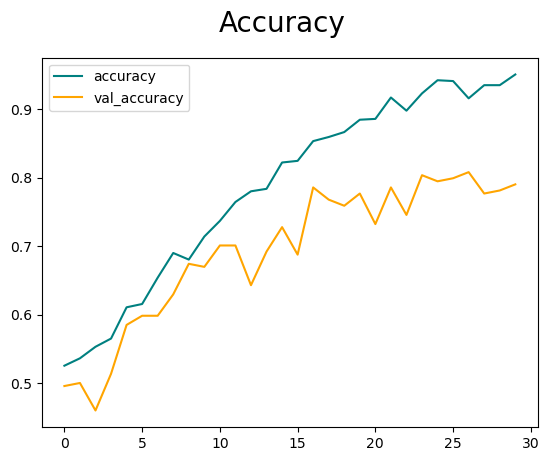

In [112]:
fig = plt.figure()
plt.plot(history_2.history['accuracy'], color='teal', label='accuracy')
plt.plot(history_2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Evaluate

In [88]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [113]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [114]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = NN_model_1.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 4s 4s/step


In [115]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.72727275, shape=(), dtype=float32) tf.Tensor(0.8888889, shape=(), dtype=float32) tf.Tensor(0.7916667, shape=(), dtype=float32)


### Test

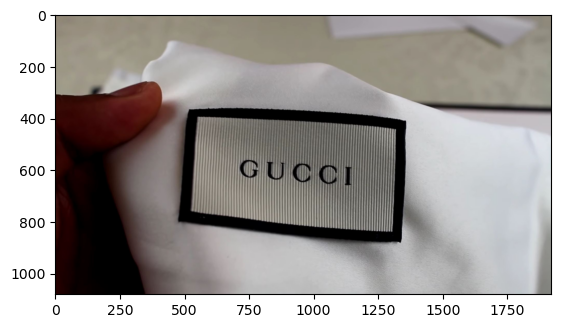

In [116]:
img = cv2.imread(r'C:\Users\ADMIN\Documents\funke_gig\dataset\img_88.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

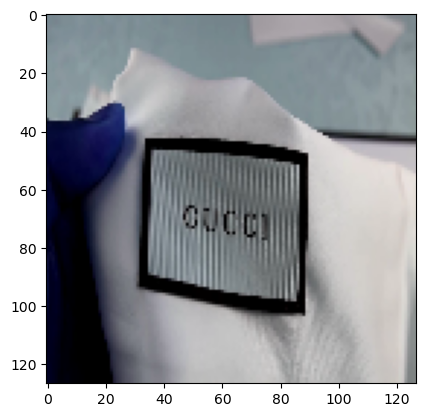

In [118]:
resize = tf.image.resize(img, (127,127))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [120]:
yhat = NN_model_1.predict(np.expand_dims(resize/127, 0))

1/1 [==============================] - 11s 11s/step


In [121]:
yhat

array([[0.9999037]], dtype=float32)

In [122]:
if yhat > 0.5: 
    print(f'Predicted class is fake')
else:
    print(f'Predicted class is authentic')

Predicted class is fake


Predicted Correctly, this is a fake Gucci

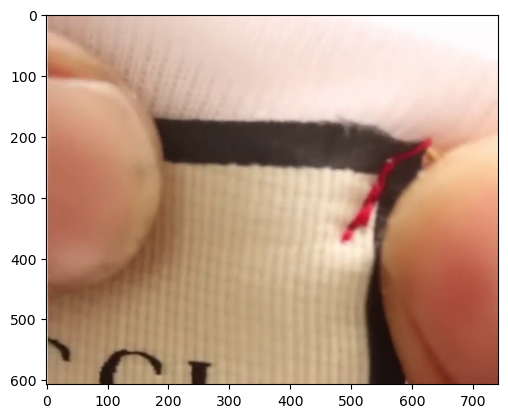

In [123]:
img = cv2.imread(r'C:\Users\ADMIN\Pictures\gucci\vlcsnap-2023-06-08-16h05m56s134 (2).png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

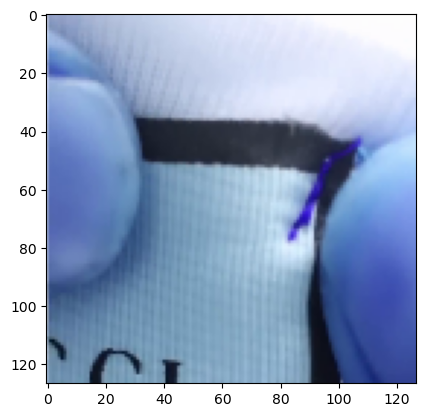

In [124]:
resize = tf.image.resize(img, (127,127))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [126]:
yhat = NN_model_1.predict(np.expand_dims(resize/127, 0))

1/1 [==============================] - 7s 7s/step


In [127]:
yhat

array([[0.09107848]], dtype=float32)

In [128]:
if yhat > 0.5: 
    print(f'Predicted class is fake')
else:
    print(f'Predicted class is authentic')

Predicted class is authentic


This prediction gave a false result.

### Save the Model

In [ ]:
#from tensorflow.keras.models import load_model

In [ ]:
#model.save(os.path.join(r'C:\Users\ADMIN\Documents\funke3','imageclassifier.h5'))

<a name="RNN"></a>
# 4. RNN MODEL

To build a Recurrent Neural Network (RNN) for image datasets, i use a specific type of RNN known as the Convolutional Recurrent Neural Network (CRNN). The CRNN combines the power of Convolutional Neural Networks (CNNs) for image processing and Recurrent Neural Networks (RNNs) for sequential data processing.

In [97]:
from tensorflow.keras.layers import LSTM

In [103]:
# Define the CRNN model
model_1 = Sequential()

In [104]:
from tensorflow.keras.layers import Reshape

# Convolutional layers
model_1.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model_1.add(MaxPooling2D())
model_1.add(Dropout(0.25))  # Add dropout layer
model_1.add(Conv2D(32, (3,3), 1, activation='relu'))
model_1.add(MaxPooling2D())
model_1.add(Dropout(0.25))  # Add dropout layer
model_1.add(Conv2D(16, (3,3), 1, activation='relu'))
model_1.add(MaxPooling2D())
model_1.add(Dropout(0.25))  # Add dropout layer
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.5))  # Add dropout layer

# Reshape output to (sequence_length, num_features) for LSTM input
model_1.add(Reshape((-1, 256)))

# RNN layers
model_1.add(LSTM(128, return_sequences=True))
model_1.add(Dropout(0.5))  # Add dropout layer
model_1.add(LSTM(128))

# Dense layers
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))




In [105]:
# Compile the model
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [106]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)       

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, LSTM

# Defined the CRNN model
model_3 = Sequential()

# Convolutional layers
model_3.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_3.add(MaxPooling2D())
model_3.add(Dropout(0.25))

model_3.add(Conv2D(128, (3, 3), activation='relu'))
model_3.add(MaxPooling2D())
model_3.add(Dropout(0.25))

model_3.add(Conv2D(256, (3, 3), activation='relu'))
model_3.add(MaxPooling2D())
model_3.add(Dropout(0.25))

model_3.add(Flatten())

# LSTM layers
model_3.add(Reshape((-1, 256)))
model_3.add(LSTM(256, return_sequences=True))
model_3.add(Dropout(0.5))
model_3.add(LSTM(128))

# Dense layers
model_3.add(Dense(512, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_3.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 63, 63, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 63, 63, 64)        0         
                                                                 
 conv2d_40 (Conv2D)          (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 30, 30, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 30, 30, 128)     

In [80]:
# Train the model
hist_5= model_3.fit(train, epochs=100, validation_data=val, batch_size = 64)#, callbacks=[tensorboard_callback, early_stopping])


Epoch 1/100
26/26 [==============================] - 124s 4s/step - loss: 0.7051 - accuracy: 0.5180 - val_loss: 0.6930 - val_accuracy: 0.5134
Epoch 2/100
26/26 [==============================] - 108s 4s/step - loss: 0.6900 - accuracy: 0.5493 - val_loss: 0.6950 - val_accuracy: 0.4821
Epoch 3/100
26/26 [==============================] - 108s 4s/step - loss: 0.6923 - accuracy: 0.5361 - val_loss: 0.6931 - val_accuracy: 0.5089
Epoch 4/100
26/26 [==============================] - 109s 4s/step - loss: 0.6943 - accuracy: 0.5120 - val_loss: 0.6919 - val_accuracy: 0.5312
Epoch 5/100
26/26 [==============================] - 109s 4s/step - loss: 0.6935 - accuracy: 0.5120 - val_loss: 0.6946 - val_accuracy: 0.5045
Epoch 6/100
26/26 [==============================] - 111s 4s/step - loss: 0.6915 - accuracy: 0.5397 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 7/100
26/26 [==============================] - 112s 4s/step - loss: 0.6914 - accuracy: 0.5457 - val_loss: 0.7035 - val_accuracy: 0.4598
Epoch 

In [83]:
# Evaluate the model
test_loss1, test_accuracy1 = model_3.evaluate(test)
print(f'Test loss: {test_loss1}, Test accuracy: {test_accuracy1}')

3/3 [==============================] - 6s 848ms/step - loss: 0.6394 - accuracy: 0.7917
Test loss: 0.6394417881965637, Test accuracy: 0.7916666865348816


In [84]:
# Make predictions
predictions1 = model_3.predict(test)

3/3 [==============================] - 7s 764ms/step


### Plot performance

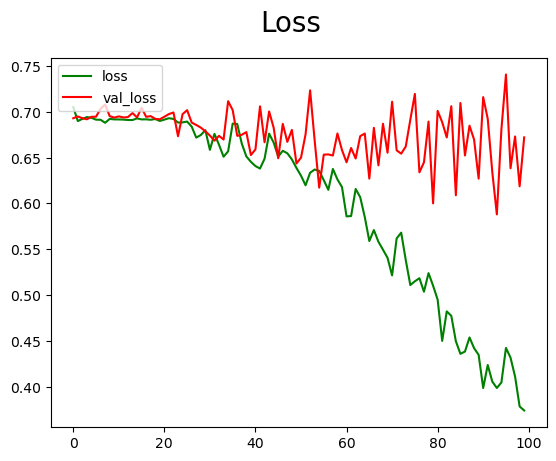

In [85]:
fig = plt.figure()
plt.plot(hist_5.history['loss'], color='green', label='loss')
plt.plot(hist_5.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

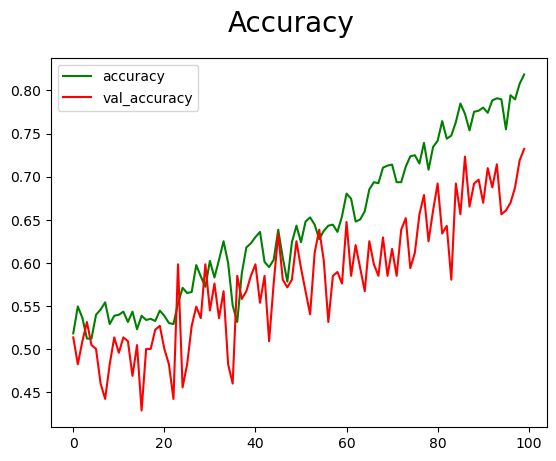

In [86]:
fig = plt.figure()
plt.plot(hist_5.history['accuracy'], color='green', label='accuracy')
plt.plot(hist_5.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Evaluate

In [89]:
pre_1 = Precision()
re_1 = Recall()
acc_1 = BinaryAccuracy()

In [91]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat_1 = model_3.predict(X)
    pre_1.update_state(y, yhat_1)
    re_1.update_state(y, yhat_1)
    acc_1.update_state(y, yhat_1)

1/1 [==============================] - 1s 825ms/step


In [92]:
print(pre_1.result(), re_1.result(), acc_1.result())

tf.Tensor(0.7, shape=(), dtype=float32) tf.Tensor(0.71428573, shape=(), dtype=float32) tf.Tensor(0.6979167, shape=(), dtype=float32)


### Test

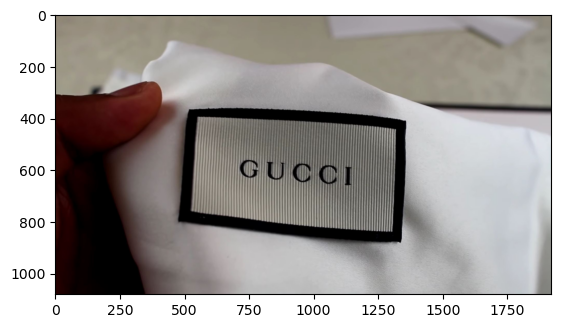

In [93]:
img_1 = cv2.imread(r'C:\Users\ADMIN\Documents\funke_gig\dataset\img_88.jpg')
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
plt.show()

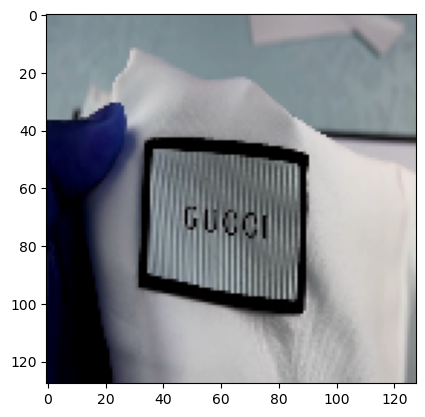

In [94]:
resize = tf.image.resize(img_1, (128,128))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [96]:
yhat_1 = model_3.predict(np.expand_dims(resize/127, 0))

1/1 [==============================] - 1s 1s/step


In [97]:
yhat_1

array([[0.02737139]], dtype=float32)

In [98]:
if yhat_1 > 0.5: 
    print(f'Predicted class is fake')
else:
    print(f'Predicted class is authentic')

Predicted class is authentic


It predicted wrongly, the result should fake

### Saving the model

In [ ]:
#model_1.save(os.path.join(r'C:\Users\ADMIN\Documents\funke3','imageclassifier_RNN.h5'))

<a name="Autoencoder"></a>
# 5. Autoencoder

In [130]:
from keras.layers import Input, Dense
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

In [141]:

# Define the input shape
input_shape = (128, 128, 3)

# Encoder
input_img = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)



In [142]:
# Autoencoder
autoencoder = Model(input_img, decoded)

In [143]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [144]:
# Print the summary of the model
autoencoder.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_61 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_62 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_63 (Conv2D)          (None, 32, 32, 64)        3692

In [145]:
train_images = []
for image, _ in train:
    train_images.append(image.numpy())

# Convert the list of images to a NumPy array
train_images = np.array(train_images)

# Reshape the training data to match the input shape of the autoencoder
train_images = train_images.reshape((-1, 128, 128, 3))

In [146]:
# Train the autoencoder
hist_2 = autoencoder.fit(train_images, train_images,
                         epochs=30,
                         batch_size=32,
                         shuffle=True)

Epoch 1/30
26/26 [==============================] - 47s 1s/step - loss: 0.0641 - accuracy: 0.4807
Epoch 2/30
26/26 [==============================] - 39s 2s/step - loss: 0.0153 - accuracy: 0.5461
Epoch 3/30
26/26 [==============================] - 37s 1s/step - loss: 0.0108 - accuracy: 0.5689
Epoch 4/30
26/26 [==============================] - 39s 2s/step - loss: 0.0083 - accuracy: 0.6158
Epoch 5/30
26/26 [==============================] - 38s 1s/step - loss: 0.0069 - accuracy: 0.6581
Epoch 6/30
26/26 [==============================] - 38s 1s/step - loss: 0.0062 - accuracy: 0.6989
Epoch 7/30
26/26 [==============================] - 42s 2s/step - loss: 0.0058 - accuracy: 0.7268
Epoch 8/30
26/26 [==============================] - 38s 1s/step - loss: 0.0054 - accuracy: 0.7566
Epoch 9/30
26/26 [==============================] - 37s 1s/step - loss: 0.0055 - accuracy: 0.7781
Epoch 10/30
26/26 [==============================] - 39s 1s/step - loss: 0.0047 - accuracy: 0.7963
Epoch 11/30
26/26 [

In [147]:
# Make predictions
predictions3 = autoencoder.predict(test)

3/3 [==============================] - 16s 325ms/step


1/1 [==============================] - 8s 8s/step


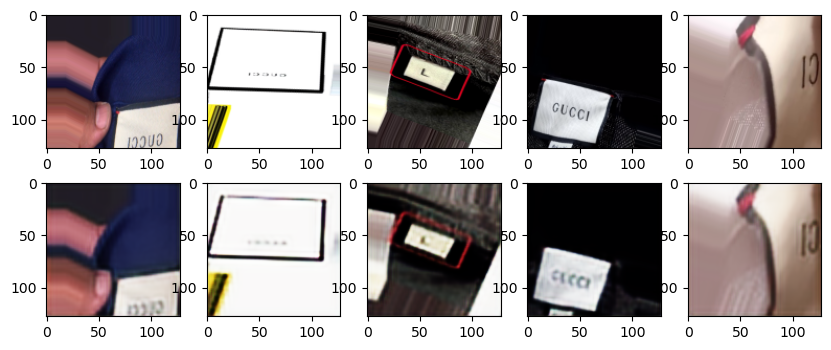

In [148]:
test_images = next(iter(data))[0][:5]
reconstructed_images = autoencoder.predict(test_images)

# Display the original and reconstructed images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    axes[0, i].imshow(test_images[i])
    axes[1, i].imshow(reconstructed_images[i])
plt.show()

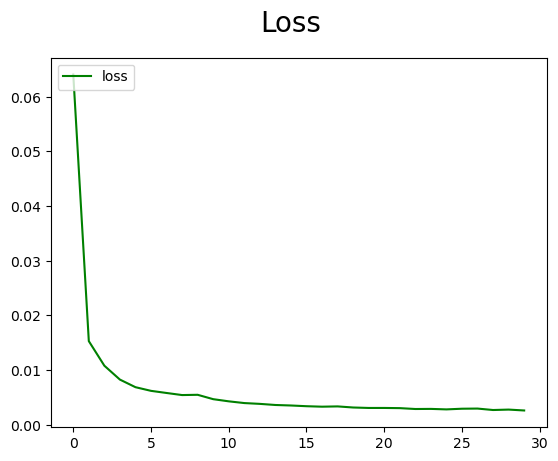

In [149]:
fig = plt.figure()
plt.plot(hist_2.history['loss'], color='green', label='loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

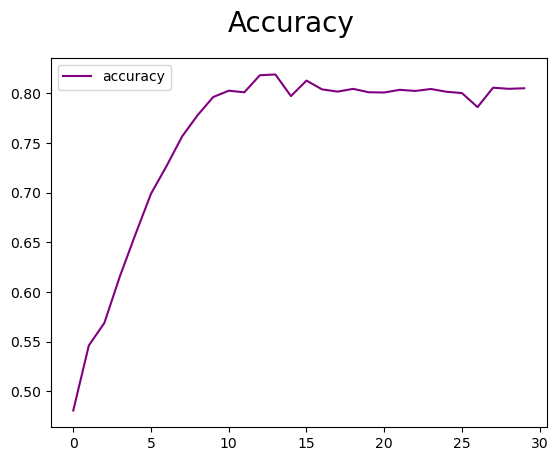

In [150]:
fig = plt.figure()
plt.plot(hist_2.history['accuracy'], color='purple', label='accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#Evaluate

In [151]:
### Table showing all the models

def create_model_summary(model):
    table = "| Layer Name | Layer Type  | Number of Parameters | Output Shape |\n"
    table += "|------------|-------------|---------------------|--------------|\n"
    
    for layer in model.layers:
        layer_name = layer.name
        layer_type = layer.__class__.__name__
        num_params = layer.count_params()
        output_shape = layer.output_shape
        
        table += f"| {layer_name} | {layer_type} | {num_params} | {output_shape} |\n"
    
    return table

# Example usage:

summary_table1 = create_model_summary(NN_model_1)
summary_table2 = create_model_summary(model_3)
summary_table3 = create_model_summary(autoencoder)

print("Summary table for CNN Model:")
print(summary_table1)
print("Summary table for RNN Model:")
print(summary_table2)
print("Summary table for Autoencoder Model:")
print(summary_table3)

Summary table for CNN Model:
| Layer Name | Layer Type  | Number of Parameters | Output Shape |
|------------|-------------|---------------------|--------------|
| conv2d_53 | Conv2D | 1792 | (None, 126, 126, 64) |
| max_pooling2d_29 | MaxPooling2D | 0 | (None, 63, 63, 64) |
| dropout_26 | Dropout | 0 | (None, 63, 63, 64) |
| conv2d_54 | Conv2D | 73856 | (None, 61, 61, 128) |
| max_pooling2d_30 | MaxPooling2D | 0 | (None, 30, 30, 128) |
| dropout_27 | Dropout | 0 | (None, 30, 30, 128) |
| conv2d_55 | Conv2D | 295168 | (None, 28, 28, 256) |
| max_pooling2d_31 | MaxPooling2D | 0 | (None, 14, 14, 256) |
| dropout_28 | Dropout | 0 | (None, 14, 14, 256) |
| flatten_12 | Flatten | 0 | (None, 50176) |
| dense_40 | Dense | 25690624 | (None, 512) |
| dropout_29 | Dropout | 0 | (None, 512) |
| dense_41 | Dense | 513 | (None, 1) |

Summary table for RNN Model:
| Layer Name | Layer Type  | Number of Parameters | Output Shape |
|------------|-------------|---------------------|--------------|
| con

### TABLE of Accuracy and Precision

In [152]:
from tabulate import tabulate

# Example data
results = [
    {"Model": "CNN Model", "Precision":  0.7188, "Accuracy":  0.9507},
    {"Model": "RNN Model", "Precision": 0.7917, "Accuracy": 0.8185},
    {"Model": "Auto-encoder Model", "Precision": 0.625, "Accuracy": 0.8051}
]

# Generate table in tabular format
table = tabulate(results, tablefmt="pipe", headers="keys")

# Print the table
print(table)

| Model              |   Precision |   Accuracy |
|:-------------------|------------:|-----------:|
| CNN Model          |      0.7188 |     0.9507 |
| RNN Model          |      0.7917 |     0.8185 |
| Auto-encoder Model |      0.625  |     0.8051 |


### Confusion Matrix

In [153]:
y_true = []
y_pred = []

for batch in test.as_numpy_iterator():
    X, y = batch
    y_hat = NN_model_1.predict(X)
    
    # Append true and predicted labels
    y_true.extend(y)
    y_pred.extend(y_hat > 0.5)  # the threshold for classifying as authentic is 0.5

1/1 [==============================] - 4s 4s/step


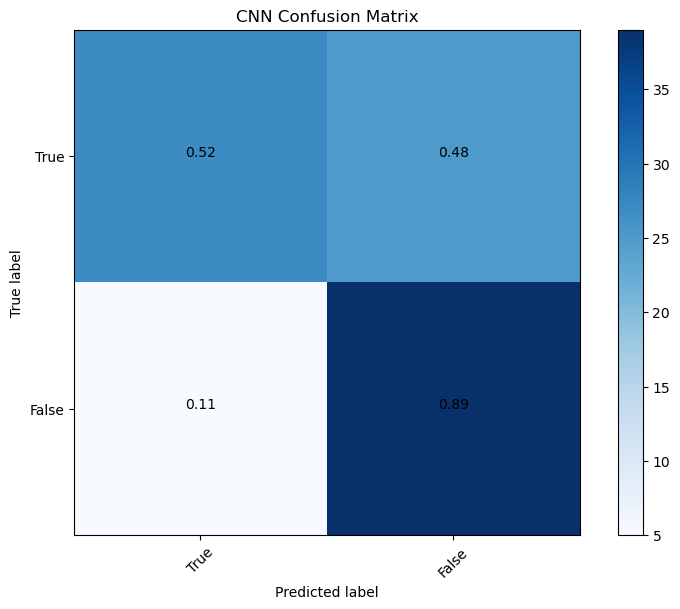

In [154]:
from sklearn.metrics import confusion_matrix
import itertools

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels 
class_labels = ['True', 'False']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('CNN Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Add labels to each cell
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm_normalized[i, j], '.2f'),
             horizontalalignment="center",
             color="white" if cm_normalized[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [155]:
y_true_1 = []
y_pred_1 = []

for batch in test.as_numpy_iterator():
    X, y = batch
    y_hat_1 = model_3.predict(X)
    
    # Append true and predicted labels
    y_true_1.extend(y)
    y_pred_1.extend(y_hat_1 > 0.5)  # threshold for classifying as authentic is 0.5

1/1 [==============================] - 5s 5s/step


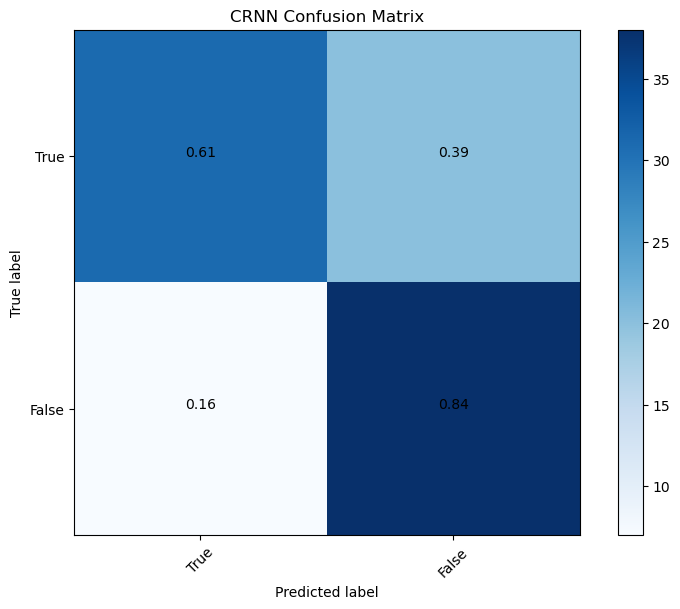

In [156]:
# Create confusion matrix for CRNN
cm = confusion_matrix(y_true_1, y_pred_1)

# Define class labels
class_labels = ['True', 'False']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('CRNN Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Add labels to each cell
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm_normalized[i, j], '.2f'),
             horizontalalignment="center",
             color="white" if cm_normalized[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<a name="Conclusion"></a>
# 6. Conclusion
The CNN outperforms Autoencoder while CRNN was the least model, so the best model was saved. Also, more data should be added to the dataset.

It's worth noting that an autoencoder is typically used for unsupervised learning and not for classification tasks, which are typically associated with precision, recall, and accuracy metrics.

In an autoencoder, the model is trained to reconstruct its input, which means the output (yhat_2) will be the reconstructed version of the input (X). Since the autoencoder is not directly performing classification, using precision, recall, and accuracy metrics in this context may not provide meaningful results.

Since we are interested in evaluating the performance of our autoencoder, it's more common to use metrics such as mean squared error (MSE) or binary cross-entropy loss to measure the reconstruction quality. These metrics compare the input (X) with the reconstructed output (yhat_2), rather than comparing them to class labels (y). In which we did.